# Introduction to optimization

A [real loss landscape](https://www.cs.umd.edu/~tomg/projects/landscapes/) for an image classification problem with a 51 layer DNN (Left and right images correspond to the same DNN with and without architecture optimization, i.e. residual connections):

<img src="https://www.cs.umd.edu/~tomg/img/landscapes/noshort.png" alt="GD variants" style="float:left; width: 300px"/>

<img src="https://www.cs.umd.edu/~tomg/img/landscapes/shortHighRes.png" alt="GD variants" style=" width: 300px"/>
<br>


In this notebook:

1. What do we want to solve? The objective function (20 min)
2. So, how would you solve this (optimization) problem? A brief overview of methods (30-40 min)
3. Simple Gradient descend implementation for one-dimensional inputs (10 min)<br> 
    3.1 Adapting the gradient size (20 min)
4. From derivatives to gradient: $n$-dimensional function minimization. (30-40 min)<br> 
    4.1 The learning rate (10 min)<br>
    
Break


5. Learning from data (10-15 min)<br> 
    5.1 Batch gradient descent (25 min)<br> 
    5.2 Stochastic gradient descent (25 min)<br> 
    5.3 Example: Linear regresion with SGD (20-30 min)<br> 
    5.4 Mini-batch gradient descent (10-20 min)<br> 
    5.5 Advanced gradient descent (30 min)<br> 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import math
import random

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
%matplotlib inline

from sklearn.datasets.samples_generator import make_regression 
from scipy import stats 

# 1. What do we want to solve? The objective function 

Let's consider the most simple case, a linear regression. Data is generated through the (unknown, if we were given just the data) process:

$\displaystyle y = 3*x + 2 + {\rm noise}$

Our network will be:

$\displaystyle \hat y = w \cdot x + b$

Finally, we want to minimize:

$\mathcal{L} = \displaystyle \sum_{\rm (x,y)} (y-\hat y)^2 = \sum_{\rm (x,y)} (y- w \cdot x - b)^2$


<div class="alert alert-success">
We want to find the values of w and b that make $\mathcal{L}$ (the cost function) minumum. Generally speaking, what we are doing is to learn a model from data, by optimizing the set of parameters that solve the problem.

<br></br>
<br></br>
Recall that we do not know how the output depends on the input!! In other words, we don't know y=f(x), that's precisely what we want to find out.
</div>

Let's find out what the cost function $\mathcal{L}(w,b)$ looks like!

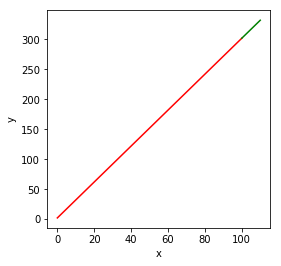

In [2]:
plt.figure(figsize=(4,4))

x_train = np.linspace(0,100,1000)
y_train = 3*x_train + 2

x_test = np.linspace(100.01, 110.01, 50)
y_test = 3*x_test+2
plt.plot(x_train, y_train, 'r')
plt.plot(x_test, y_test, 'g')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Let's calculate the loss for fixed x and y

In [ ]:
# take a random pair (x0, y0)
index = 
x0 = 
y0 = 

In [ ]:
# Calculate the loss 
def loss(x, y, w, b):
    return 

In [ ]:
# give values to the parameters w and b
w = 
b = 

In [ ]:
# plot w and b
plt.figure(figsize=(4,4))

plt.plot(w, loss(x0, y0, w, 2), label='weight');
plt.plot(b, loss(x0, y0, 2, b), label='bias');
plt.legend(loc=1);

In [ ]:
# make a mesh grid, to see how the loss varies as function of w and b
X,Y = np.meshgrid(w, b)
Z = loss(x_train[index], y_train[index], X, Y)

In [ ]:
fig, ax = plt.subplots(figsize=(5,4))

p = ax.pcolor(X, Y, Z, cmap=plt.cm.RdBu, vmin=abs(Z).min(), vmax=abs(Z).max())
cb = fig.colorbar(p)
plt.xlabel('w')
plt.ylabel('b')
plt.show()

In [ ]:
fig, ax = plt.subplots()

ax = fig.add_subplot(1, 2, 1, projection='3d')

# p = ax.plot_surface(X, Y, Z, rstride=4, cstride=4, linewidth=0)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, linewidth=0,  cmap='viridis')
plt.xlabel('w')
plt.ylabel('b')
plt.show()

# 2. So, how would you solve this (optimization) problem? 
## A brief overview of methods, before  we get our hands dirty

The mathematical discipline that studies this kind of problems is called [Automatic Differentiation (AD)](https://en.wikipedia.org/wiki/Automatic_differentiation), and the [Back-propagation algorithm](https://en.wikipedia.org/wiki/Backpropagation) used to optimize Artificial Neural Networks is a special case of AD (we'll get back to this later). 

<img src="https://upload.wikimedia.org/wikipedia/commons/6/6e/Grafico_3d_x2%2Bxy%2By2.png" alt="convex problem" style="float: center; width: 300px"/>


The optimization problems are divided in two main parts: linear and [non-linear programming](https://en.wikipedia.org/wiki/Nonlinear_programming), depending on whether the constraints defining the objective function and its parameters are linear or not. Among nonlinear problems, the [convex ones](https://en.wikipedia.org/wiki/Convex_optimization) are the only ones who have guaranteed a solution, because they have a global minima (a convex function is shown in the figure below; any segment between two points of the functions lies aboove or on the graph itself). The linear regression example we saw earlier on this notebook is an example of convex optimization (a quite simple one). 

<img src="https://upload.wikimedia.org/wikipedia/commons/c/c7/ConvexFunction.svg" alt="convex function" style="width: 450px"/>


**Unfortunately, most problems of interest are not convex and, therefore, they present multiple local minima**. Even a convex problem can become non-convex in the presence of noise, see the figures below!

<img src="http://www.turingfinance.com/wp-content/uploads/2015/07/Quadratic-Function.png" alt="convex problem" style="float: left; width: 300px"/>

<img src="http://www.turingfinance.com/wp-content/uploads/2014/09/Noisy-Quadratic-Surface.png" alt="non convex problem" style="width: 300px"/>

<br>
But, as Yann LeCun put it, ["Who is afraid of non-convex functions?"](https://cs.nyu.edu/~yann/talks/lecun-20071207-nonconvex.pdf)

<div class="alert alert-success">
Even the simplest NN can constitute a non-convex optimization problem, because of the non-linearity of the activations, the objective function or the data itself! Thus, we don't have any guarantee that a solution exist. And this is why training NN is so difficult (no matter what they tell you ;) )

</div>

AD is solved by means of **iterative methods** that approximate the minimum or maximum of an objective function in a multidimensional space. There are many iterative methods, being some of the most well known:

* [Nelder-Mead](https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method): kind of brute force searching mechanism. It has severe problems as the number of dimensions of the problem increases.

<img src="https://upload.wikimedia.org/wikipedia/commons/e/e4/Nelder-Mead_Rosenbrock.gif" alt="convex problem" style="float: center; width: 300px"/>

* [Newthon method](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization): very accurate, but it requires information on the second derivative (the [Hessian matrix](https://en.wikipedia.org/wiki/Hessian_matrix), that describes the local curvature of the surface). It's very expensive to calculate, though!

<img src="https://upload.wikimedia.org/wikipedia/commons/d/da/Newton_optimization_vs_grad_descent.svg" alt="newton vs GD" style="float: center; width: 300px"/>


* [Quasi-netownian methods](https://en.wikipedia.org/wiki/Quasi-Newton_method): since calculating 2nd order derivatives (the Hessian) is expensive, these family of methods try to approximate the Hessian in different forms =) The most well known algorithms are [BFGS](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm) and [L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS). They work pretty well, but they have severe memory problems and  do not scale to large datasets (there are some studies trying to incorporate batches).


* [Gradient-descent](https://en.wikipedia.org/wiki/Gradient_descent) Ok, forget about the second derivative! Just use the first-order approximation ;) It's slower than previous methods, but it works for any number of variables/dimensions. 

<img src="https://blog.paperspace.com/content/images/2018/06/firstorder.png" alt="stupid GD" style="float: center; width: 600px"/>


...[Subgradient methods](https://en.wikipedia.org/wiki/Subgradient_method)


Other resources:

http://www.benfrederickson.com/numerical-optimization/

http://ruder.io/optimizing-gradient-descent/

https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

https://towardsdatascience.com/gradient-descent-in-a-nutshell-eaf8c18212f0

https://github.com/DeepLearningUB/DeepLearningMaster/blob/master/1.%20Basic%20Concepts.ipynb

Other methods, in case you are interested:

* [Simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing): a Monte Carlo like search, in which the state of minimum "energy" (a.k.a. cost) is find by performing probabilistic jumps between states.

<img src="https://upload.wikimedia.org/wikipedia/commons/1/10/Travelling_salesman_problem_solved_with_simulated_annealing.gif" alt="stupid GD" style="float: center; width: 600px"/>


* [Genetic algorithms](https://en.wikipedia.org/wiki/Genetic_algorithm): monte carlo search, inspired by the mechanism of natural selection observed in Nature (genetic errors, marriage of individuals, and so on). It has regained attention recently in the AI community, after [OpenAI](https://openai.com/) showed its success in solving  [Reinforcement Learning problems](https://blog.openai.com/evolution-strategies/). 

<div class="alert alert-success">
In the following we will try to understand gradient descent and variants of it, but you should keep in mind the problems and assumptions we have highligthed!
</div>

# 3. Simple Gradient descend implementation

Some parts of the following code are taken from [the UB Master in DL](https://github.com/DeepLearningUB/DeepLearningMaster/blob/master/1.%20Basic%20Concepts.ipynb).

Gradient descent is an optimization algorithm used to find the values of parameters (coefficients) of a function (f) that minimizes a cost function (cost).Gradient descent is best used when the parameters cannot be calculated analytically (e.g. using linear algebra) and must be searched for by an optimization algorithm.Gradient descent is used to find the minimum error by minimizing a “cost” function.

<img src="https://i.stack.imgur.com/w7ARo.png" alt="down the hill" style="float: right; width: 700px"/>


To find the local minimum using **gradient descend**: you start at a random point, and move into the direction of steepest **descent** relative to the derivative:

+ Start from a random $x$ value.
+ Compute the derivative $f'(x)$ analitically.
+ Walk a small step in the **opposite** direction of the derivative. 



In this example, let's consider the function $f(x) = x^2-6x+5$. The minimum occurs at $x=3$.

In [ ]:
x = np.linspace(-1,5,100)
f = x**2-6*x+5
plt.plot(x, f)
plt.show()

Following the steps above, suppose we start at $x=15$. The derivative at this point is $2×15−6=24$. 

Because we're using gradient descent, we need to subtract the gradient from our $x$-coordinate: the new position is $x1 =x - f'(x) = 15-24 = -9$. However, notice that $15−24$ gives us $−9$, clearly overshooting over target of $3$. 

In [ ]:
x = np.linspace(-10,20,100)
y = x**2 - 6*x + 5
start = 15

fig, ax = plt.subplots(1, 1)
plt.plot(x,y, 'r-')
plt.plot([start],[start**2 - 6*start + 5],'o')
ax.text(start,
        start**2 - 6*start + 35,
        'Start',
        ha='center',
        color=sns.xkcd_rgb['blue'],
       )

d = 2 * start - 6
end = start - d

plt.plot([end],[end**2 - 6*end + 5],'o')
plt.ylim([-10,250])
plt.gcf().set_size_inches((10,3))
plt.grid(True)
ax.text(end,
        start**2 - 6*start + 35,
        'End',
        ha='center',
        color=sns.xkcd_rgb['green'],
       )
plt.show()

## 3.1 Adapting the gradient size

To fix this, we multiply the gradient by a step size. This step size (often called **alpha**) has to be chosen carefully, as a value too small will result in a long computation time, while a value too large will not give you the right result (by overshooting) or even fail to converge. 

In this example, we'll set the step size to 0.01, which means we'll subtract $24×0.01$ from $15$, which is $14.76$. 

This is now our new temporary local minimum: We continue this method until we either don't see a change after we subtracted the derivative step size, or until we've completed a pre-set number of iterations.

In [ ]:
old_min = 0  # old minima
temp_min = 15  # tempora minima
step_size = 0.01  # size of the steps we make i nthe direction of the gradient
precision = 0.0001  # a tolerance criteria for stopping the iterative process

def f(x):
    return x**2 - 6*x + 5
    
def f_derivative(x):
    return 

mins = []
cost = []

while abs(temp_min - old_min) > precision:
    old_min = temp_min 
    gradient =  # calculate the derivative
    move =  # make a step in the direction of the gradient
    temp_min =  # new minima
    cost.append((3-temp_min)**2) # just the squared differnece with the known minima (3.0, in this example)
    mins.append(temp_min)

# rounding the result to 2 digits because of the step size
print("Local minimum occurs at {:3.6f}.".format(round(temp_min,2)))

An important feature of gradient descent is that **there should be a visible improvement over time**: In this example, we simply plotted the squared distance from the local minima calculated by gradient descent and the true local minimum,  ``cost``, against the iteration during which it was calculated. As we can see, the distance gets smaller over time, but barely changes in later iterations. 

In [ ]:
x = np.linspace(-10,20,100)
y = x**2 - 6*x + 5

x, y = (zip(*enumerate(cost)))

fig, ax = plt.subplots(1, 1)
plt.plot(x,y, 'r-', alpha=0.7)
plt.ylim([-10,150])
plt.gcf().set_size_inches((10,3))
plt.grid(True)
plt.ylabel('Cost')
plt.xlabel('Iterations')
plt.show();

fig, ax = plt.subplots(1, 1)
plt.semilogy(x,y, 'r-', alpha=0.7)
plt.gcf().set_size_inches((10,3))
plt.grid(True)
plt.ylabel('Cost (log scale)')
plt.xlabel('Iterations')
plt.show();

In [ ]:
x = np.linspace(-10,20,100)
y = x**2 - 6*x + 5

fig, ax = plt.subplots(1, 1)
plt.plot(x,y, 'r-')
plt.ylim([-10,250])
plt.gcf().set_size_inches((10,3))
plt.grid(True)
plt.plot(mins,cost,'o', alpha=0.3)
ax.text(start,
        start**2 - 6*start + 25,
        'Start',
        ha='center',
        color=sns.xkcd_rgb['blue'],
       )
ax.text(mins[-1],
        cost[-1]+20,
        'End (%s steps)' % len(mins),
        ha='center',
        color=sns.xkcd_rgb['blue'],
       )
plt.show();

# 4 From derivatives to gradient: $n$-dimensional function minimization.

Let's consider a $n$-dimensional function $f: \mathbb{R}^n \rightarrow \mathbb{R}$. Note this is actually a quite common case: it can be, for instance, the mapping from a image to a label "dog" or "no dog"; or the result of a sentiment analysis, that maps a sentence to a "positve" or "negative" sentiment. 

As a simple exmaple, we shall take:

$$f(\mathbf{x}) = \sum_{n} x_n^2$$

Our objective is to find the argument  $\mathbf{x}$ that minimizes this function.

The **gradient** of $f$ is the vector whose components are the $n$ partial derivatives of $f$. It **is thus a vector-valued function**. 

The gradient points in the direction of the greatest rate of **increase** of the function.

$$\nabla {f} = (\frac{\partial f}{\partial x_1}, \dots, \frac{\partial f}{\partial x_n})$$

In [ ]:
# implement \sum x_i^2
def f(x):
    return 

def fin_dif_partial_centered(x, 
                             f, 
                             i, 
                             h=1e-6):
    '''
    This method returns the partial derivative of the i-th component of f at x
    by using the centered finite difference method
    
    (f(x+h) - f(x-h))/2h
    '''
    w1 =  # vector at x+h
    w2 =  # vector at x-h
    diff = # difference of the function at those points
    return diff/(2*h)

def gradient_centered(x, 
                      f, 
                      h=1e-6):
    '''
    This method returns the gradient vector of f at x
    by using the centered finite difference method
    '''
    return[round(fin_dif_partial_centered(x,f,i,h), 10) for i,_ in enumerate(x)]

The function we have evaluated, $f({\mathbf x}) = x_1^2+x_2^2+x_3^2$, is $3$ at $(1,1,1)$ and the gradient vector at this point is $(2,2,2)$. 

In [ ]:
x = [1.0,1.0,1.0]

print('{:.6f}'.format(f(x)), gradient_centered(x,f))

Then, we can follow this steps to maximize (or minimize) the function:

+ Start from a random $\mathbf{x}$ vector.
+ Compute the gradient vector.
+ Walk a small step in the opposite direction of the gradient vector.

> It is important to be aware that this gradient computation is very expensive: if $\mathbf{x}$ has dimension $n$, we have to evaluate $f$ at $2*n$ points.


### How to use the gradient.

$f(x) = \sum_i x_i^2$, takes its mimimum value when all $x$ are 0. 

Let's check it for $n=3$: 

In [ ]:
# we need this funtion to evaluate the distance between two points.
def euc_dist(v1,v2):
    v = np.array(v1)-np.array(v2)
    return math.sqrt(sum(v_i ** 2 for v_i in v))

Let's start by choosing a random vector and then walking a step in the opposite direction of the gradient vector. We will stop when the difference between the new solution and the old solution is less than a tolerance value.

In [ ]:
# choosing a random vector
x = 

In [ ]:
# calculate the gradient


In [ ]:
def step(x,
         grad,
         alpha):
    '''
    This function makes a step in the opposite direction of the gradient vector 
    in order to compute a new value for the target function.
    '''
    return 

tol = 1e-15
alpha = 0.01
k = 0 # to count the number of steps
old_x = x
while True:
    k += 1
    grad = gradient_centered(old_x,f)
    next_x = step(old_x,grad,alpha)
    if euc_dist(next_x, old_x) < tol:
        break
    old_x = next_x
print("Found a minimum at ", [round(i,10) for i in next_x], " in %s steps" %k)

## 4.1 The learning rate alpha

The step size, **alpha**, is a slippy concept: if it is too small we will slowly converge to the solution, if it is too large we can diverge from the solution. 

There are several policies to follow when selecting the step size:

+ Constant size steps. In this case, the size step determines the precision of the solution.
+ Decreasing step sizes.
+ At each step, select the optimal step.

The last policy is good, but too expensive. Try, for instance, dividing the step size by 2 at each iteration

In [ ]:
tol = 1e-15
alpha = 0.01
k = 0 # to count the number of steps
old_x = x
while True:
    k += 1
    grad = gradient_centered(old_x,f)
    next_x = step(old_x,grad,alpha)
    if euc_dist(next_x, old_x) < tol:
        break
    old_x = next_x
    alpha /= 2.0
print("Found a minimum at ", [round(i,10) for i in next_x], " in %s steps." %k)

For more information, take a look [here](https://towardsdatascience.com/understanding-learning-rates-and-how-it-improves-performance-in-deep-learning-d0d4059c1c10)

# 5. Learning from data

In general, we have:

+ A dataset $(\mathbf{x},y)$ of $n$ examples. 
+ An objective function $J_{\boldsymbol \theta}$, that we want to minimize, representing the **discrepancy between our data and the model** we want to fit. The model is represented by a set of parameters ${\boldsymbol \theta}$. 
+ The gradient of the target function, $g_f$. 


In the most common case $f$ represents the errors from a data representation model $M$. To fit the model is to find the optimal parameters $\boldsymbol \theta$ that minimize the following expression:

$$ J_{\boldsymbol \theta} = \frac{1}{n} \sum_{i} (y_i - M(\mathbf{x}_i,{\boldsymbol \theta}))^2 $$

For example, $(\mathbf{x},y)$ can represent:

+ $\mathbf{x}$: the behavior of a "Candy Crush" player; $y$: monthly payments. 
+ $\mathbf{x}$: sensor data about your car engine; $y$: probability of engine error.
+ $\mathbf{x}$: finantial data of a bank customer; $y$: customer rating.

> If $y$ is a real value, it is called a *regression* problem.

> If $y$ is binary/categorical, it is called a *classification* problem. 

## 5.1 Batch gradient descend

Let's suppose that our model is a one-dimensional linear model $M(\mathbf{x},{\boldsymbol \theta}) = w \cdot x $. 

**Batch gradient descend** consists of calculating the gradients for all the points, averaging, and updating the parameters accordingly.

$$\frac{\partial J}{\partial \theta_j}=\frac{2}{n} \sum_{i} \frac{\partial M}{\partial \theta_j} (M-y_i) $$

$$\theta_j \leftarrow \theta_j - \alpha\cdot\frac{\partial J}{\partial \theta_j}$$

$${\boldsymbol \theta} \leftarrow {\boldsymbol\theta} - \alpha\nabla J_{\boldsymbol\theta}$$

In [ ]:
import numpy as np
import random

# f = 2x
x = np.arange(10)
y = 

# f_target = 1/n Sum (y - wx)**2
def target_f(x,y,w):
    return 

# gradient respect to w: dJ_dw = 2/n Sum (wx-y)*x
def gradient_f(x,y,w):
    return 

def step(w,grad,alpha):
    # one dimensional updates
    return 

In [ ]:
def BGD(target_f, 
        gradient_f, 
        x, 
        y, 
        toler = 1e-6, 
        alpha=0.01):
    '''
    Batch gradient descend by using a given step
    '''
    
        

In [ ]:
print('{:.6f}'.format(BGD(target_f, gradient_f, x, y)))

In [ ]:
# note that selecting the step size is tricky
for alpha in [1e-4, 1e-3, 1e-2, 1.2e-2, 1.5e-2, 1.7e-2, 1.75e-2]:
    %%timeit BGD(target_f, gradient_f, x, y, alpha=alpha)

We could also use a multi-step approach for the learning rate

The main advantages of BGD are:

* We can use fixed step size.
* It has a straight trajectory towards the minimum and it is guaranteed to converge in theory to the global minimum if the loss function is convex and to a local minimum if the loss function is not convex. In other words, we are using the tru gradient. 
* It has unbiased estimate of gradients. The more the examples, the lower the standard error.

The main disadvantages:

* Even though we can use vectorized implementation, it may still be slow to go over all examples especially when we have large datasets.
* Each step of learning happens after going over all examples where some examples may be redundant and don’t contribute much to the update.


<div class="alert alert-success">
Note that the number of data pairs $({\bf x}, y)$ can be very large (millions, billions, etc.). Thus, **the calculation the cost $J_{\bf w}$ for all points can be very costly, and sometimes, unfeasible for memory reasons!** Different implementations of BGD are required, hence. 
</div>

## 5.2 Stochastic Gradient Descend

The last function evals the whole dataset $(\mathbf{x}_i,y_i)$ at every step. If the dataset is large, this methodology is way too costly. Instead of that, we will use a strategy called **SGD** (*Stochastic Gradient Descend*): the idea is to perform parameter updates at each point.

When learning from data, the cost function is additive: it is computed by adding sample reconstruction errors. Therefore, we can compute an estimate of the gradient (and move towards the minimum) by using only **one data sample** (or a small data sample). We will find the minimum by iterating this gradient estimation over the dataset.

A full iteration over the dataset is called **epoch**. Before each epoch, data must be randomly shuffled. 

<div class="alert alert-success">
So, if we are not using the true gradient, but rather a noisy version, can we find the minimum?
</div>

<img src="http://ruder.io/content/images/2016/09/sgd_fluctuation.png">
<center>(Fluctuations in the loss with SGD, from Wikipedia)</center>

If we apply this method we have some theoretical guarantees to find a good minimum:
+ SGD essentially uses the inaccurate gradient per iteration. Since there is no free lunch, what is the cost by using approximate gradient? The answer is that the convergence rate is slower than the gradient descent algorithm.
+ The convergence of SGD has been analyzed using the theories of convex minimization and of stochastic approximation: it converges almost surely to a global minimum when the objective function is convex or pseudoconvex, and otherwise converges almost surely to a local minimum.

<div class="alert alert-success">
There is an unexpected advantage when using SGD in large dimensional data: the stochastic update of parameters prevents the optimization from ending up in saddle points!
</div>

In [ ]:
x = np.arange(10)
y = np.array([2*i for i in x])
data = np.vstack((x, y)).T

for xi in data:
    print('{:3d} {:3d}'.format(xi[0], xi[1]))
print()

def in_random_order(data):
    '''
    Random data generator
    '''
    d = data.copy()
    np.random.shuffle(d)
    return d

for xi in in_random_order(data):
    print('{:3d} {:3d}'.format(xi[0], xi[1]))

In [ ]:
def SGD(target_f, 
        gradient_f, 
        x, 
        y, 
        toler = 1e-6, 
        epochs=100, 
        alpha=0.01):
    '''
    Stochastic gradient descend
    '''
    # stack the data
    data = np.vstack((x, y)).T
    # random initialization of the weight
    w = random.random()
    
    min_w, min_val = float('inf'), float('inf')
    epoch = 0
    while epoch < epochs:
        val = target_f(x, y, w)
        if min_val - val > toler:
            min_w, min_val = w, val
        
        for xi in in_random_order(data):
            gradient_i = gradient_f(xi[0], xi[1], w)
            w = w - (alpha *  gradient_i)
            
        epoch += 1
    return min_w

In [ ]:
x = np.arange(10)
y = np.array([3*i for i in x])

print('w: {:.6f}'.format(SGD(target_f, gradient_f, x, y, epochs=100, alpha=1e-2)))

<div class="alert alert-success">
Play with different values. Try increasing the number of points in x. Do you need to change the number of epochs? And the step size alpha?

</div>

## 5.3 Exercise: Stochastic Gradient Descent and Linear Regression

The linear regression model assumes a linear relationship between data:

$$ y_i = w_1 x_i + w_0 $$

Let's generate a more realistic dataset (with noise), where $w_1 = 2$ and $w_0 = 0$.

In [ ]:
%reset
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_regression 
from scipy import stats 
import random

%matplotlib inline

In [ ]:
# x: input data
# y: noisy output data

x = np.random.uniform(0,1,20)

# f = 2x + 0
def f(x): return 2*x + 0

noise_variance =0.1
noise = np.random.randn(x.shape[0])*noise_variance
y = f(x) + noise

fig, ax = plt.subplots(1, 1)
plt.xlabel('$x$', fontsize=15)
plt.ylabel('$f(x)$', fontsize=15)
plt.plot(x, y, 'o', label='y')
plt.plot([0, 1], [f(0), f(1)], 'b-', label='f(x)')
plt.ylim([0,2])
plt.gcf().set_size_inches((10,3))
plt.grid(True)
plt.show()

Complete the following code in order to:
+ Compute the value of $w$ by using a estimator based on minimizing the squared error.
+ Get from SGD function a vector, `target_value`, representing the value of the target function at each iteration.


In [ ]:
# Write your target function as f_target 1/n Sum (y - wx)**2
def target_f(x,y,w):
    # your code here
    return

# Write your gradient function
def gradient_f(x,y,w):
    # your code here
    return

def in_random_order(data):
    '''
    Random data generator
    '''
    import random
    indexes = [i for i,_ in enumerate(data)]
    random.shuffle(indexes)
    for i in indexes:
        yield data[i]

# Modify the SGD function to return a 'target_value' vector
def SGD(target_f, 
        gradient_f, 
        x, 
        y, 
        toler = 1e-6, 
        epochs=100, 
        alpha_0=0.01):
    
    # Insert your code among the following lines
    target_value = []
    
    data = list(zip(x,y))
    w = random.random()
    alpha = alpha_0
    min_w, min_val = float('inf'), float('inf')
    iteration_no_increase = 0
    epoch = 0
    while epoch < epochs and iteration_no_increase < 100:
        val = target_f(x, y, w)
        if min_val - val > toler:
            min_w, min_val = w, val
            alpha = alpha_0
            iteration_no_increase = 0
        else:
            iteration_no_increase += 1
            alpha *= 0.95
        
        target_value.append(val)
        epoch += 1
    return min_w, target_value

In [ ]:
# Print the value of the solution
w, target_value = SGD(target_f, gradient_f, x, y, epochs=100, alpha_0=1e-2)
print('w: {:.6f}'.format(w))

In [ ]:
# Visualize the solution regression line

fig, ax = plt.subplots(1, 1)
plt.plot(x, y, 'o', label='t')
plt.plot([0, 1], [f(0), f(1)], 'b-', label='f(x)', alpha=0.5)
plt.plot([0, 1], [0*w, 1*w], 'r-', label='fitted line', alpha=0.5, linestyle='--')
plt.xlabel('input x')
plt.ylabel('target t')
plt.title('input vs. target')
plt.ylim([0,2])
plt.gcf().set_size_inches((10,3))
plt.grid(True)
plt.show()

In [ ]:
# Visualize the evolution of the target function value during iterations.

fig, ax = plt.subplots(1, 1)
plt.plot(np.arange(len(target_value)), target_value, 'o', alpha = 0.2)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.grid()
plt.gcf().set_size_inches((10,3))
plt.grid(True)
plt.show()

## 5.4 Mini-batch Gradient Descent

In code, general **batch gradient descent** looks something like this:

```python
nb_epochs = 100
for i in range(nb_epochs):
    grad = evaluate_gradient(target_f, data, w)
    w = w - learning_rate * grad
```

For a pre-defined number of epochs, we first compute the gradient vector of the target function for the whole dataset w.r.t. our parameter vector. 

**Stochastic gradient descent** (SGD) in contrast performs a parameter update for each training example and label:

```python
nb_epochs = 100
for i in range(nb_epochs):
    np.random.shuffle(data)
    for sample in data:
        grad = evaluate_gradient(target_f, sample, w)
        w = w - learning_rate * grad
```

**Mini-batch gradient descent** finally takes the best of both worlds and performs an update for every mini-batch of $n$ training examples:

```python
nb_epochs = 100
for i in range(nb_epochs):
  np.random.shuffle(data)
  for batch in get_batches(data, batch_size=50):
    grad = evaluate_gradient(target_f, batch, w)
    w = w - learning_rate * grad
```

Minibatch SGD has the advantage that it works with a slightly less noisy estimate of the gradient. However, as the minibatch size increases, the number of updates done per computation done decreases (eventually it becomes very inefficient, like batch gradient descent). 

There is an optimal trade-off (in terms of computational efficiency) that may vary depending on the data distribution and the particulars of the class of function considered, as well as how computations are implemented.

<img src="https://cdn-images-1.medium.com/max/1600/1*PV-fcUsNlD9EgTIc61h-Ig.png" alt="GD variants" style="float: center; width: 700px"/>

In [ ]:
def get_batches(iterable, 
                num_elem_batch = 1):
    '''
    Generator of batches from an iterable that contains data
    '''
    current_batch = []
    for item in iterable:
        current_batch.append(item)
        if len(current_batch) == num_elem_batch:
            yield current_batch
            current_batch = []
    if current_batch:
        yield current_batch

x = np.array(range(0, 10))
y = np.array(range(10, 20))
data = list(zip(x,y))
np.random.shuffle(data)
for x in get_batches(data, 3):
    print(x)

print

for batch in get_batches(data, 3):
    print(np.array(list(zip(*batch))[0]), np.array(list(zip(*batch))[1]))

In [ ]:
%reset
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_regression 
from scipy import stats 
import random

%matplotlib inline

In [ ]:
# x: input data
# y: noisy output data

x = np.random.uniform(0,1,2000)

# f = 2x + 0
def f(x): return 2*x + 0

noise_variance =0.1
noise = np.random.randn(x.shape[0])*noise_variance
y = f(x) + noise

plt.plot(x, y, 'o', label='y')
plt.plot([0, 1], [f(0), f(1)], 'b-', label='f(x)')
plt.xlabel('$x$', fontsize=15)
plt.ylabel('$t$', fontsize=15)
plt.ylim([0,2])
plt.title('inputs (x) vs targets (y)')
plt.grid()
plt.legend(loc=2)
plt.gcf().set_size_inches((10,3))
plt.show()

In [ ]:
# f_target = 1/n Sum (y - wx)**2
def target_f(x,
             y,
             w):
    return np.sum((y - x * w)**2.0) / x.size

# gradient_f = 2/n Sum 2wx**2 - 2xy
def gradient_f(x,
               y,
               w):
    return 2 * np.sum(2*w*(x**2) - 2*x*y) / x.size

def in_random_order(data):
    '''
    Random data generator
    '''
    import random
    indexes = [i for i,_ in enumerate(data)]
    random.shuffle(indexes)
    for i in indexes:
        yield data[i]
        
def get_batches(iterable, 
                num_elem_batch = 1):
    '''
    Generator of batches from an iterable that contains data
    '''
    current_batch = []
    for item in iterable:
        current_batch.append(item)
        if len(current_batch) == num_elem_batch:
            yield current_batch
            current_batch = []
    if current_batch:
        yield current_batch

def SGD_MB(target_f, gradient_f, x, y, epochs=100, alpha_0=0.01):
    data = list(zip(x,y))
    w = random.random()
    alpha = alpha_0
    min_w, min_val = float('inf'), float('inf')
    epoch = 0
    while epoch < epochs:
        val = target_f(x, y, w)
        if val < min_val:
            min_w, min_val = w, val
            alpha = alpha_0
        else:
            alpha *= 0.9
        np.random.shuffle(data)
        for batch in get_batches(data, num_elem_batch = 100):
            x_batch = np.array(list(zip(*batch))[0])
            y_batch = np.array(list(zip(*batch))[1])
            gradient = gradient_f(x_batch, y_batch, w)
            w = w - (alpha *  gradient)
        epoch += 1
    return min_w

In [ ]:
w = SGD_MB(target_f, gradient_f, x, y)
print('w: {:.6f}'.format(w))

In [ ]:
plt.plot(x, y, 'o', label='t')
plt.plot([0, 1], [f(0), f(1)], 'b-', label='f(x)', alpha=0.5)
plt.plot([0, 1], [0*w, 1*w], 'r-', label='fitted line', alpha=0.5, linestyle='--')
plt.xlabel('input x')
plt.ylabel('target t')
plt.ylim([0,2])
plt.title('input vs. target')
plt.grid()
plt.legend(loc=2)
plt.gcf().set_size_inches((10,3))
plt.show()

## Advanced gradient descend

There are a number of problems faced by the vanilla mini-batch GD, as explained by Sebastian Ruder in this [excellent post](http://ruder.io/optimizing-gradient-descent/):

* **Choosing a proper learning rate can be difficult**. A learning rate that is too small leads to painfully slow convergence, while a learning rate that is too large can hinder convergence and cause the loss function to fluctuate around the minimum or even to diverge.

* Learning rate schedules try to adjust the learning rate during training by e.g. annealing, i.e. reducing the learning rate according to a pre-defined schedule or when the change in objective between epochs falls below a threshold. These schedules and thresholds, however, have to be defined in advance and are thus unable to adapt to a dataset's characteristics.

* Additionally, **the same learning rate applies to all parameter updates**. If our data is sparse and our features have very different frequencies, we might not want to update all of them to the same extent, but perform a larger update for rarely occurring features.

* Another **key challenge** of minimizing highly non-convex error functions common for neural networks is **avoiding getting trapped in their numerous suboptimal local minima**. Dauphin et al. [19] argue that the difficulty arises in fact not from local minima but from **saddle points**, i.e. points where one dimension slopes up and another slopes down. These saddle points are usually surrounded by a plateau of the same error, which makes it notoriously hard for SGD to escape, as the gradient is close to zero in all dimensions.

Related to this last point, we have: 

* **Ill-conditioning of the Hessian matrix**: regions where the curvature around one variable is much larger than in other directions (like in a ravine).

* **Plateaus**, or flat regions, where there is no gradient and therefore the optimizer gets trapped.

The following methods try to prevent some of these problems.


<img src="http://2.bp.blogspot.com/-q6l20Vs4P_w/VPmIC7sEhnI/AAAAAAAACC4/g3UOUX2r_yA/s1600/s25RsOr%2B-%2BImgur.gif">

(Image credit: Alec Radford) 

<img src="https://i.imgur.com/2dKCQHh.gif?1">

(Image credit: Alec Radford) 


### Momentum: remember what you have already done

SGD has trouble navigating ravines, i.e. areas where the surface curves much more steeply in one dimension than in another, which are common around local optima. In these scenarios, SGD oscillates across the slopes of the ravine while only making hesitant progress along the bottom towards the local optimum.

<img src="http://ruder.io/content/images/2015/12/without_momentum.gif">
<img src="http://ruder.io/content/images/2015/12/with_momentum.gif">

Momentum is a method that helps accelerate SGD in the relevant direction and dampens oscillations. It does this by adding a fraction of the update vector of the past time step to the current update vector:

$$ v_t = m v_{t-1} + \alpha \nabla_w f $$
$$ w = w - v_t    $$

The momentum $m$ is commonly set to $0.9$.


### Adagrad: a learning rate for each parameter

All previous approaches manipulated the learning rate globally and equally for all parameters. Tuning the learning rates is an expensive process, so much work has gone into devising methods that can adaptively tune the learning rates, and even do so per parameter. 

Adagrad is an algorithm for gradient-based optimization that does just this: It adapts the learning rate to the parameters, performing larger updates for infrequent and smaller updates for frequent parameters.

$$ c = c + (\nabla_w f)^2 $$
$$ w = w - \frac{\alpha}{\sqrt{c}}\nabla_w f $$ 


### RMProp

RMSprop is an unpublished, adaptive learning rate method proposed by Geoff Hinton in [Lecture 6e of his Coursera Class](http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf).

RMSProp update adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate. In particular, it uses a moving average of squared gradients instead, giving:

$$ c = \beta c + (1 - \beta)(\nabla_w f)^2 $$
$$ w = w - \frac{\alpha}{\sqrt{c}}\nabla_w f $$ 

where $\beta$ is a decay rate that controls the size of the moving average (typically, $\beta=0.9$..

Take a look at [this video](https://www.coursera.org/lecture/deep-neural-network/rmsprop-BhJlm) by Andrew NG.

In [ ]:
%reset

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_regression 
from scipy import stats 
import random

%matplotlib inline

In [ ]:
# the function that I'm going to plot
def f(x,y):
    return x**2 + 5*y**2

x = np.arange(-3.0,3.0,0.1)
y = np.arange(-3.0,3.0,0.1)
X,Y = np.meshgrid(x, y, indexing='ij') # grid of point
Z = f(X, Y) # evaluation of the function on the grid

plt.pcolor(X, Y, Z, cmap=plt.cm.gist_earth)
plt.axis([x.min(), x.max(), y.min(), y.max()])
plt.gca().set_aspect('equal', adjustable='box')
plt.gcf().set_size_inches((6,6))
plt.show()

In [ ]:
def target_f(x):
    return x[0]**2.0 + 5*x[1]**2.0

def part_f(x, 
           f, 
           i, 
           h=1e-6):
    w1 = [x_j + (h if j==i else 0) for j, x_j in enumerate(x)]
    w2 = [x_j - (h if j==i else 0) for j, x_j in enumerate(x)]
    return (f(w1) - f(w2))/(2*h)

def gradient_f(x, 
               f, 
               h=1e-6):
    return np.array([round(part_f(x,f,i,h), 10) for i,_ in enumerate(x)])

In [ ]:
def SGD(target_f, 
        gradient_f, 
        x, 
        alpha_0=0.01,
        toler = 0.000001):
    alpha = alpha_0
    min_val = float('inf')
    steps = 0
    iteration_no_increase = 0
    trace = []
    while iteration_no_increase < 100:
        val = target_f(x)
        if min_val - val > toler:
            min_val = val
            alpha = alpha_0
            iteration_no_increase = 0
        else:
            alpha *= 0.95
            iteration_no_increase += 1
        trace.append(val)
        gradient_i = gradient_f(x, target_f)
        x = x - (alpha *  gradient_i)
        steps += 1
    return x, val, steps, trace

x = np.array([2,-2])
x, val, steps, trace = SGD(target_f, gradient_f, x)
print(x)
print('Val: {:.6f}, steps: {:.0f}'.format(val, steps))

In [ ]:
def SGD_M(target_f, 
        gradient_f, 
        x, 
        alpha_0=0.01,
        toler = 0.000001,
        m = 0.9):
    
    alpha = alpha_0
    min_val = float('inf')
    steps = 0
    iteration_no_increase = 0
    v = 0.0
    trace = []
    while iteration_no_increase < 100:
        val = target_f(x)
        if min_val - val > toler:
            min_val = val
            alpha = alpha_0
            iteration_no_increase = 0
        else:
            alpha *= 0.95
            iteration_no_increase += 1
        trace.append(val)
        gradient_i = gradient_f(x, target_f)
        v = m * v + (alpha *  gradient_i)
        x = x - v
        steps += 1
    return x, val, steps, trace

x = np.array([2,-2])
x, val, steps, trace2 = SGD_M(target_f, gradient_f, x)

print('\n',x)
print('Val: {:.6f}, steps: {:.0f}'.format(val, steps))

In [ ]:
x2 = np.array(range(len(trace)))
x3 = np.array(range(len(trace2)))
plt.xlim([0,len(trace)])
plt.gcf().set_size_inches((10,3))
plt.semilogy(x3, trace2, '--')
plt.semilogy(x2, trace, '-')
plt.show()